In [40]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 500)  # let pd.df display() 500 rows
pd.set_option('display.max_columns', 500)

### Import data

- wave ADNI1, ADNIGO as training

- wave ADNI2, ADNI3 as testing

In [15]:
x_train = pd.read_csv("../clean_data/mci_wv1go.csv")    
x_test = pd.read_csv("../clean_data/mci_wv23.csv")
y_train = x_train.pop("progress")
y_test = x_test.pop("progress")

In [52]:
# light gbm:
mod_lgb = lgb.LGBMClassifier()
mod_lgb.fit(x_train, y_train)
pred_train = mod_lgb.predict(x_train) 
pred_test = mod_lgb.predict(x_test) 

array([[9.99623356e-01, 3.76643656e-04],
       [9.94117489e-01, 5.88251078e-03],
       [9.90680022e-01, 9.31997842e-03],
       ...,
       [9.99027275e-01, 9.72725038e-04],
       [9.22540661e-03, 9.90774593e-01],
       [9.99117652e-01, 8.82347828e-04]])

In [31]:
f"light gbm train: {np.mean(pred_train == y_train)}, test: {np.mean(pred_test == y_test)}"

'light gbm train: 1.0, test: 0.908'

In [32]:
# xgboost:
mod_xgb = xgb.XGBClassifier()
mod_xgb.fit(x_train, y_train)
pred_train = mod_xgb.predict(x_train) 
pred_test = mod_xgb.predict(x_test) 

In [33]:
f"xgboost train: {np.mean(pred_train == y_train)}, test: {np.mean(pred_test == y_test)}"

'xgboost train: 1.0, test: 0.892'

In [35]:
# catboost:
mod_cat = CatBoostClassifier()
mod_cat.fit(x_train, y_train)
pred_train = mod_cat.predict(x_train) 
pred_test = mod_cat.predict(x_test) 

Learning rate set to 0.00908
0:	learn: 0.6859674	total: 76.2ms	remaining: 1m 16s
1:	learn: 0.6785048	total: 79.7ms	remaining: 39.8s
2:	learn: 0.6717685	total: 83.1ms	remaining: 27.6s
3:	learn: 0.6664185	total: 86.4ms	remaining: 21.5s
4:	learn: 0.6601245	total: 89.1ms	remaining: 17.7s
5:	learn: 0.6545602	total: 92.1ms	remaining: 15.3s
6:	learn: 0.6476309	total: 94.6ms	remaining: 13.4s
7:	learn: 0.6410286	total: 96.9ms	remaining: 12s
8:	learn: 0.6345053	total: 99.2ms	remaining: 10.9s
9:	learn: 0.6285740	total: 102ms	remaining: 10.1s
10:	learn: 0.6226803	total: 104ms	remaining: 9.32s
11:	learn: 0.6151251	total: 106ms	remaining: 8.71s
12:	learn: 0.6096535	total: 108ms	remaining: 8.2s
13:	learn: 0.6020775	total: 110ms	remaining: 7.74s
14:	learn: 0.5965495	total: 112ms	remaining: 7.34s
15:	learn: 0.5921028	total: 114ms	remaining: 6.99s
16:	learn: 0.5848748	total: 116ms	remaining: 6.7s
17:	learn: 0.5797500	total: 117ms	remaining: 6.39s
18:	learn: 0.5730645	total: 119ms	remaining: 6.14s
19:	le

188:	learn: 0.2693499	total: 393ms	remaining: 1.68s
189:	learn: 0.2685682	total: 394ms	remaining: 1.68s
190:	learn: 0.2679182	total: 396ms	remaining: 1.68s
191:	learn: 0.2674658	total: 398ms	remaining: 1.67s
192:	learn: 0.2670030	total: 400ms	remaining: 1.67s
193:	learn: 0.2662867	total: 402ms	remaining: 1.67s
194:	learn: 0.2655222	total: 405ms	remaining: 1.67s
195:	learn: 0.2648909	total: 406ms	remaining: 1.67s
196:	learn: 0.2640185	total: 409ms	remaining: 1.67s
197:	learn: 0.2635530	total: 411ms	remaining: 1.67s
198:	learn: 0.2629605	total: 413ms	remaining: 1.66s
199:	learn: 0.2622674	total: 415ms	remaining: 1.66s
200:	learn: 0.2618048	total: 416ms	remaining: 1.65s
201:	learn: 0.2610392	total: 419ms	remaining: 1.65s
202:	learn: 0.2605236	total: 421ms	remaining: 1.65s
203:	learn: 0.2601329	total: 422ms	remaining: 1.65s
204:	learn: 0.2596058	total: 424ms	remaining: 1.64s
205:	learn: 0.2593331	total: 426ms	remaining: 1.64s
206:	learn: 0.2588411	total: 427ms	remaining: 1.64s
207:	learn: 

444:	learn: 0.1745259	total: 906ms	remaining: 1.13s
445:	learn: 0.1741781	total: 908ms	remaining: 1.13s
446:	learn: 0.1739276	total: 911ms	remaining: 1.13s
447:	learn: 0.1736735	total: 914ms	remaining: 1.13s
448:	learn: 0.1733317	total: 916ms	remaining: 1.12s
449:	learn: 0.1732112	total: 918ms	remaining: 1.12s
450:	learn: 0.1730776	total: 919ms	remaining: 1.12s
451:	learn: 0.1728806	total: 921ms	remaining: 1.12s
452:	learn: 0.1726916	total: 923ms	remaining: 1.11s
453:	learn: 0.1725181	total: 925ms	remaining: 1.11s
454:	learn: 0.1723084	total: 927ms	remaining: 1.11s
455:	learn: 0.1719392	total: 928ms	remaining: 1.11s
456:	learn: 0.1717916	total: 930ms	remaining: 1.1s
457:	learn: 0.1715540	total: 932ms	remaining: 1.1s
458:	learn: 0.1711312	total: 934ms	remaining: 1.1s
459:	learn: 0.1709853	total: 935ms	remaining: 1.1s
460:	learn: 0.1708572	total: 937ms	remaining: 1.09s
461:	learn: 0.1705790	total: 938ms	remaining: 1.09s
462:	learn: 0.1704102	total: 940ms	remaining: 1.09s
463:	learn: 0.17

663:	learn: 0.1329780	total: 1.27s	remaining: 642ms
664:	learn: 0.1327691	total: 1.27s	remaining: 640ms
665:	learn: 0.1326737	total: 1.27s	remaining: 638ms
666:	learn: 0.1326296	total: 1.27s	remaining: 636ms
667:	learn: 0.1323929	total: 1.27s	remaining: 634ms
668:	learn: 0.1321587	total: 1.28s	remaining: 632ms
669:	learn: 0.1318722	total: 1.28s	remaining: 630ms
670:	learn: 0.1316077	total: 1.28s	remaining: 628ms
671:	learn: 0.1313142	total: 1.28s	remaining: 626ms
672:	learn: 0.1311353	total: 1.28s	remaining: 624ms
673:	learn: 0.1309527	total: 1.28s	remaining: 622ms
674:	learn: 0.1307478	total: 1.29s	remaining: 620ms
675:	learn: 0.1304748	total: 1.29s	remaining: 617ms
676:	learn: 0.1304030	total: 1.29s	remaining: 615ms
677:	learn: 0.1301593	total: 1.29s	remaining: 613ms
678:	learn: 0.1300363	total: 1.29s	remaining: 611ms
679:	learn: 0.1297954	total: 1.29s	remaining: 609ms
680:	learn: 0.1295705	total: 1.3s	remaining: 607ms
681:	learn: 0.1293835	total: 1.3s	remaining: 606ms
682:	learn: 0.

894:	learn: 0.0989643	total: 1.65s	remaining: 193ms
895:	learn: 0.0989055	total: 1.65s	remaining: 192ms
896:	learn: 0.0988595	total: 1.65s	remaining: 190ms
897:	learn: 0.0986987	total: 1.65s	remaining: 188ms
898:	learn: 0.0985217	total: 1.66s	remaining: 186ms
899:	learn: 0.0984069	total: 1.66s	remaining: 184ms
900:	learn: 0.0982422	total: 1.66s	remaining: 182ms
901:	learn: 0.0979671	total: 1.66s	remaining: 180ms
902:	learn: 0.0977808	total: 1.66s	remaining: 178ms
903:	learn: 0.0976289	total: 1.66s	remaining: 177ms
904:	learn: 0.0976026	total: 1.66s	remaining: 175ms
905:	learn: 0.0975703	total: 1.67s	remaining: 173ms
906:	learn: 0.0974414	total: 1.67s	remaining: 171ms
907:	learn: 0.0973261	total: 1.67s	remaining: 169ms
908:	learn: 0.0972494	total: 1.67s	remaining: 167ms
909:	learn: 0.0972116	total: 1.67s	remaining: 165ms
910:	learn: 0.0969769	total: 1.67s	remaining: 164ms
911:	learn: 0.0969277	total: 1.68s	remaining: 162ms
912:	learn: 0.0968903	total: 1.68s	remaining: 160ms
913:	learn: 

In [36]:
f"catboost train: {np.mean(pred_train == y_train)}, test: {np.mean(pred_test == y_test)}"

'catboost train: 0.9946236559139785, test: 0.924'

In [42]:
mod_gbm = HistGradientBoostingClassifier()
mod_gbm.fit(x_train, y_train)
pred_train = mod_gbm.predict(x_train) 
pred_test = mod_gbm.predict(x_test) 

In [43]:
f"GBM train: {np.mean(pred_train == y_train)}, test: {np.mean(pred_test == y_test)}"

'GBM train: 1.0, test: 0.9'

### MICE Imputation

In [83]:
# import miceforest as mf
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
mod_log = Pipeline([
    # ("scale",StandardScaler() ),
    ('impute', KNNImputer()),
    ('model', LogisticRegression()),
])
mod_log.fit(x_train, y_train)
pred_train = mod_log.predict(x_train) 
pred_test = mod_log.predict(x_test) 
f"logR train: {np.mean(pred_train == y_train)}, test: {np.mean(pred_test == y_test)}"

/opt/anaconda3/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'logR train: 0.8346774193548387, test: 0.88'

### Evaluation

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

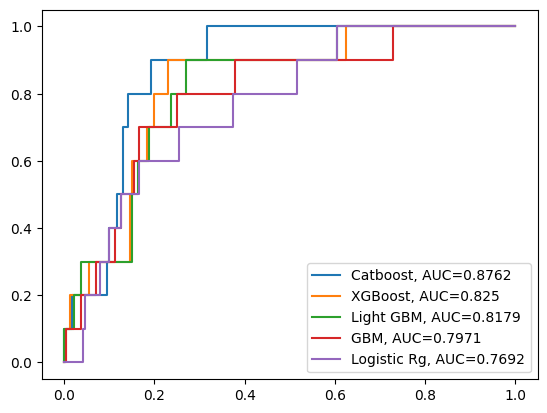

In [85]:
plt.figure(0).clf()
# Catboost:
y_pred = mod_cat.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Catboost, AUC="+str(auc))
# xgboost:
y_pred = mod_xgb.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))
# light gbm:
y_pred = mod_lgb.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Light GBM, AUC="+str(auc))

# hist gbm:
y_pred = mod_gbm.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="GBM, AUC="+str(auc))

# Logistic:
y_pred = mod_log.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Rg, AUC="+str(auc))


plt.legend()

